In [ ]:
!pip install peft accelerate rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=4f5193b878b3b02230b49f84c86235f821cba31ed958a121f06ef183f3cf529c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import os
import matplotlib.pyplot as plt
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from peft import get_peft_model, LoraConfig, TaskType
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

In [ ]:
import os
import matplotlib.pyplot as plt
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

model_name = 'microsoft/phi-2'
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS (Metal Performance Shaders) on Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Fallback to CPU if neither is available

model.to(device)

# Load dataset and split into train and validation, using fewer data points for quicker evaluation
full_data = pd.read_csv("hf://datasets/s-nlp/paradetox/train.tsv", sep="\t").sample(1000, random_state=42)  # Use a smaller sample of 1000 data points
_, val_data = train_test_split(full_data, test_size=0.1, random_state=42)

# Load validation data
x_test = tokenizer(val_data["en_toxic_comment"].tolist(), return_tensors="pt", truncation=True, padding=True)
y_test = val_data["en_neutral_comment"].tolist()

# Move inputs to device
x_test = {k: v.to(device) for k, v in x_test.items()}

# Make predictions
model.eval()
predictions = []
for i in range(len(x_test["input_ids"])):
    inputs = {k: v[i:i+1] for k, v in x_test.items()}  # Select one example at a time
    output = model.generate(**inputs, num_return_sequences=1, do_sample=False, num_beams=5, max_new_tokens=50)
    print(f"Generated output for input {i+1}/{len(x_test['input_ids'])}")
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(prediction)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 1/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 2/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 3/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 4/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 5/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 6/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 7/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 8/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 9/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 10/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 11/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 12/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 13/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 14/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 15/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 16/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 17/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 18/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 19/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 20/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 21/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 22/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 23/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 24/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 25/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 26/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 27/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 28/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 29/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 30/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 31/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 32/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 33/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 34/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 35/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 36/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 37/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 38/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 39/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 40/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 41/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 42/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 43/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 44/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 45/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 46/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 47/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 48/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 49/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 50/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 51/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 52/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 53/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 54/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 55/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 56/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 57/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 58/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 59/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 60/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 61/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 62/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 63/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 64/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 65/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 66/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 67/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 68/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 69/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 70/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 71/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 72/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 73/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 74/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 75/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 76/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 77/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 78/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 79/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 80/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 81/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 82/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 83/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 84/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 85/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 86/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 87/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 88/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 89/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 90/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 91/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 92/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 93/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 94/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 95/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 96/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 97/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 98/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output for input 99/100
Generated output for input 100/100


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU Score: 0.07553601862700714
Average ROUGE Scores: {'rouge1': 0.26858049210852825, 'rouge2': 0.1961183286844156, 'rougeL': 0.2631554220094182}


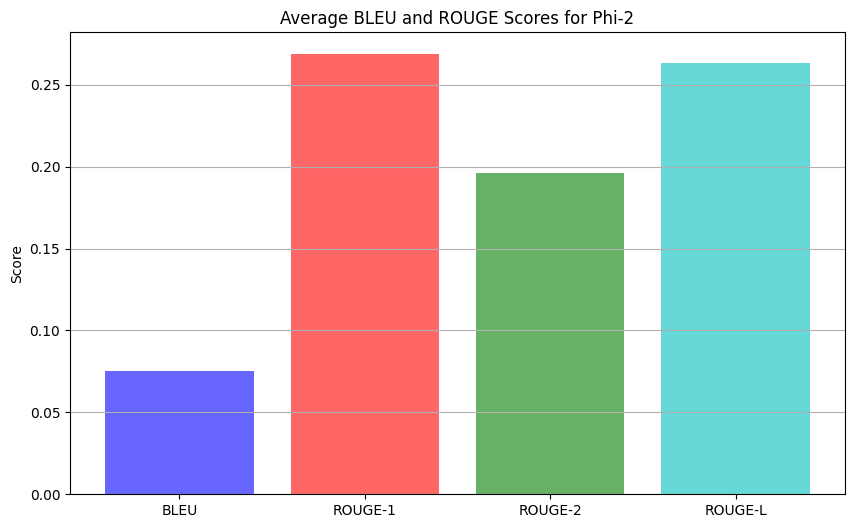

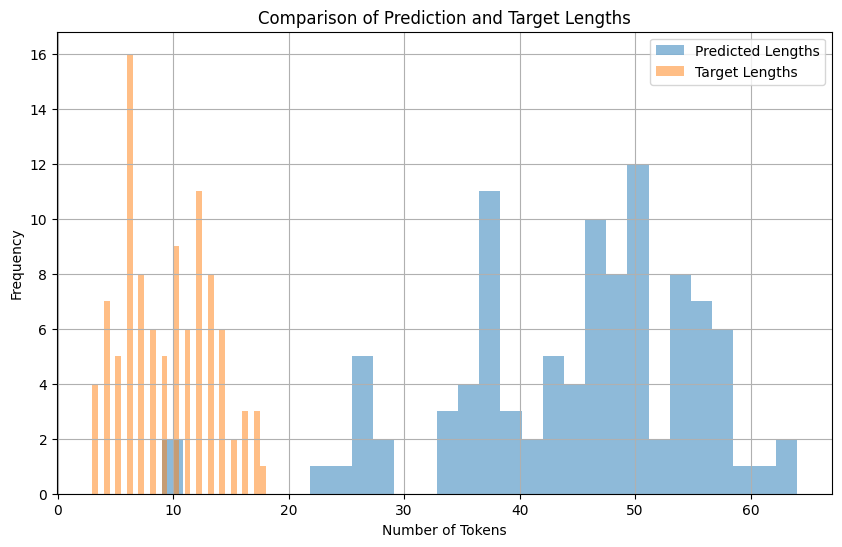

In [ ]:

# Evaluate using BLEU and ROUGE
references = [ref.split() for ref in y_test]  # Convert references to list of tokens
predictions_split = [pred.split() for pred in predictions]

# BLEU Score Calculation
bleu_scores = [sentence_bleu([ref], pred) for ref, pred in zip(references, predictions_split)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# ROUGE Score Calculation
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, pred) for ref, pred in zip(y_test, predictions)]

average_rouge_score = {
    "rouge1": sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores),
    "rouge2": sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores),
    "rougeL": sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
}

print("Average BLEU Score:", average_bleu_score)
print("Average ROUGE Scores:", average_rouge_score)

# Plotting Average Scores
plt.figure(figsize=(10, 6))

# Plotting Average BLEU Score
plt.bar(['BLEU'], [average_bleu_score], color='b', alpha=0.6)

# Plotting Average ROUGE Scores
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [average_rouge_score['rouge1'], average_rouge_score['rouge2'], average_rouge_score['rougeL']]
plt.bar(rouge_labels, rouge_values, color=['r', 'g', 'c'], alpha=0.6)

plt.ylabel('Score')
plt.title('Average BLEU and ROUGE Scores for Phi-2')
plt.grid(axis='y')
plt.show()

pred_lengths = [len(p.split()) for p in predictions]
target_lengths = [len(t.split()) for t in y_test]

plt.figure(figsize=(10, 6))
plt.hist(pred_lengths, alpha=0.5, bins=30, label='Predicted Lengths')
plt.hist(target_lengths, alpha=0.5, bins=30, label='Target Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Comparison of Prediction and Target Lengths')
plt.legend()
plt.grid(True)
plt.show()





In [ ]:

# Create a table for the scores
table_data = [
    ["Metric", "Score"],
    ["BLEU", average_bleu_score],
    ["ROUGE-1", average_rouge_score['rouge1']],
    ["ROUGE-2", average_rouge_score['rouge2']],
    ["ROUGE-L", average_rouge_score['rougeL']]
]

In [ ]:
from tabulate import tabulate


In [ ]:
print("Phi-2 Results")
print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))


Phi-2 Results
+---------+---------------------+
| Metric  |        Score        |
+---------+---------------------+
|  BLEU   | 0.07553601862700714 |
| ROUGE-1 | 0.26858049210852825 |
| ROUGE-2 | 0.1961183286844156  |
| ROUGE-L | 0.2631554220094182  |
+---------+---------------------+


In [21]:
print("Without Training")
sample_data = {
    'Input': val_data['en_toxic_comment'].iloc[:5].tolist(),
    'Prediction': predictions[:5],
    'Ground Truth': y_test[:5]
}
sample_df = pd.DataFrame(sample_data)
print(tabulate(sample_df, headers='keys', tablefmt='pretty'))

Without Training
+---+-----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+
|   |                                          Input                                          |                                                                                                                  Prediction                                                                                                                  |                           Ground Truth                            |
+---+-----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------